# Purpose
* calculate the `log_probability` of the model as shown [Figure 2.29 from MBML](https://www.mbmlbook.com/LearningSkills_Learning_the_guess_probabilities.html)

In [1]:
import operator
import sys
from functools import reduce
from typing import List, Tuple

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Latex as lt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.funsor import config_enumerate, enum, infer_discrete
from numpyro.handlers import seed, trace
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, log_likelihood
from numpyro.infer.util import Predictive, log_density, potential_energy

In [2]:
rng_key = jax.random.PRNGKey(2)

In [3]:
skills_key = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-Quiz-SkillsQuestionsMask.csv",
    header=None,
)
skills_needed = []
for index, row in skills_key.iterrows():
    skills_needed.append([i for i, x in enumerate(row) if x])

responses = pd.read_csv(
    "http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-IsCorrect.csv",
    header=None,
)

responses = responses.astype("int32")

In [4]:
def model_00(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [5]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, jnp.array(responses), skills_needed)
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1200/1200 [01:46<00:00, 11.25it/s, 1 steps of size 1.19e+37. acc. prob=1.00] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 skill_0[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[2]      0.01      0.10      0.00      0.00      0.00   4093.80      1.00
 skill_0[3]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[4]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[5]      0.00      0.00      0.00      0.00      0.00       nan       nan
 skill_0[6]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[7]      1.00      0.02      1.00      1.00      1.00       nan      1.00
 skill_0[8]      0.99      0.12      1.00      1.00      1.00   4130.52      1.00
 skill_0[9]      1.00      0.00      1.00      1.00      1.00       nan       nan
skill_0[10]      1.00      0.02      1.00      1.00      1.00       nan      1.00
skill_0[11]    

In [6]:
ds = az.from_numpyro(mcmc)

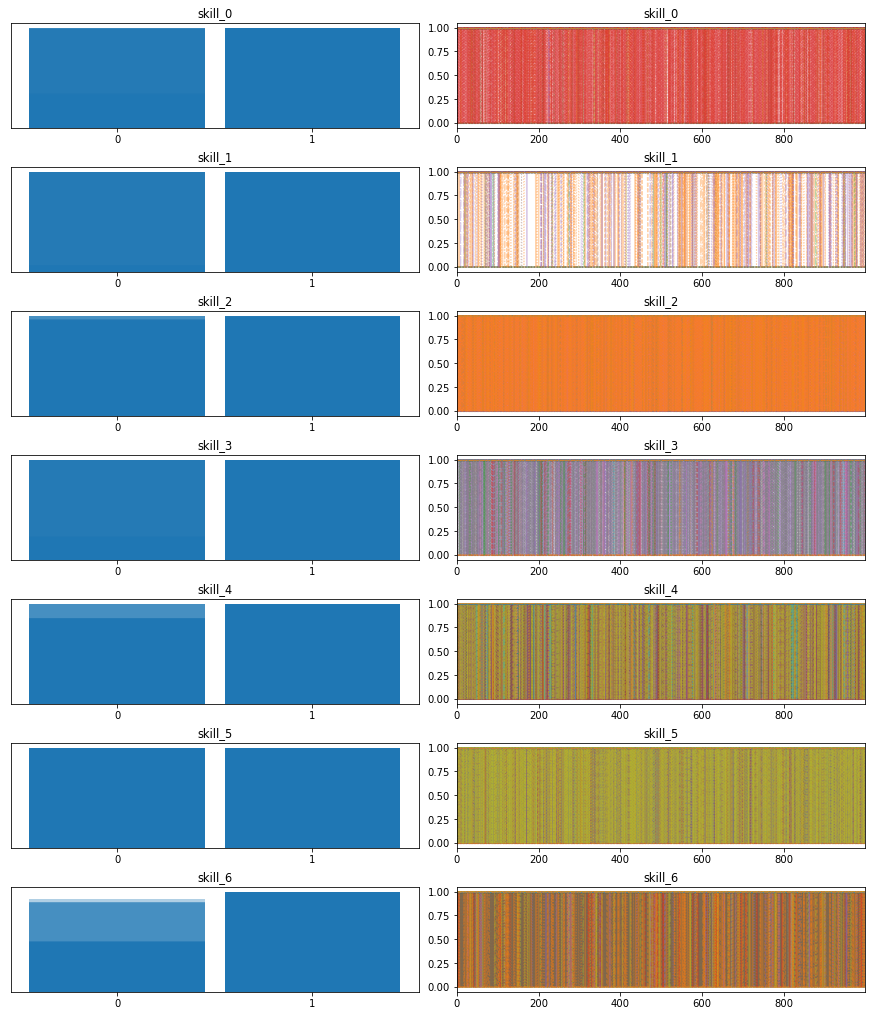

In [7]:
az.plot_trace(ds);

In [9]:
log_density_model_00 = log_density(model_00, (jnp.array(responses), skills_needed), dict(prob_mistake=0.1, prob_guess=0.2), mcmc.get_samples())

In [11]:
log_density_model_00[0]

DeviceArray(-2474509.8, dtype=float32)

In [12]:
def model_02(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1,
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    with numpyro.plate("questions_plate", n_questions):
        prob_guess = numpyro.sample("prob_guess", dist.Beta(2.5, 7.5))

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess[q]
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [13]:
nuts_kernel = NUTS(model_02)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc_02 = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc_02.run(rng_key, jnp.array(responses), skills_needed)
mcmc_02.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1200/1200 [02:09<00:00,  9.30it/s, 7 steps of size 4.65e-01. acc. prob=0.84]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 prob_guess[0]      0.26      0.12      0.24      0.05      0.43   4018.62      1.00
 prob_guess[1]      0.28      0.12      0.27      0.07      0.46   4985.69      1.00
 prob_guess[2]      0.32      0.12      0.31      0.12      0.52   5196.04      1.00
 prob_guess[3]      0.33      0.13      0.32      0.11      0.53   3749.15      1.00
 prob_guess[4]      0.29      0.12      0.28      0.08      0.47   5087.65      1.00
 prob_guess[5]      0.20      0.11      0.19      0.03      0.37   4913.97      1.00
 prob_guess[6]      0.40      0.13      0.39      0.18      0.60   4370.26      1.00
 prob_guess[7]      0.38      0.13      0.37      0.17      0.60   5587.07      1.00
 prob_guess[8]      0.39      0.13      0.38      0.16      0.59   3703.78      1.00
 prob_guess[9]      0.32      0.13      0.31      0.10      0.52   4171.06      1.00
prob_guess[10]      0.30      0.13      0.29      0.10      0.50

In [14]:
ds = az.from_numpyro(mcmc_02)

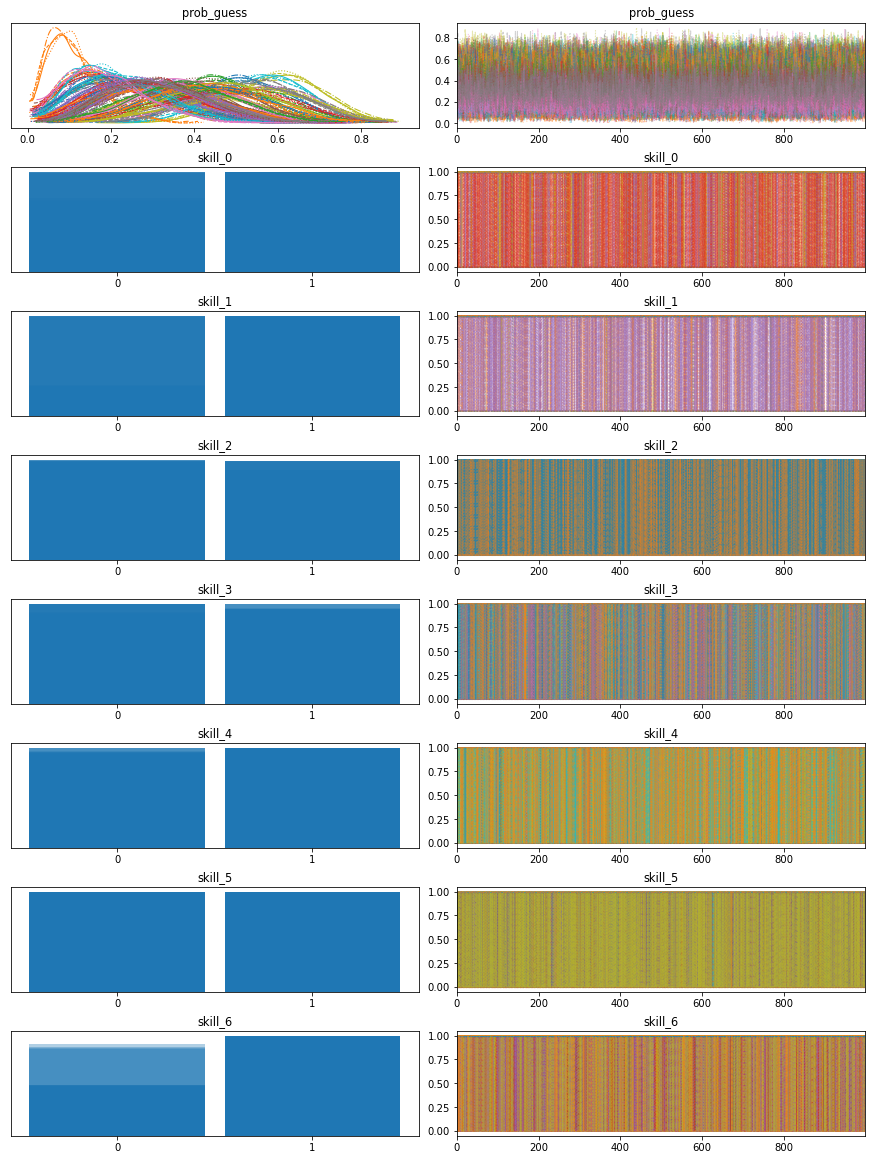

In [15]:
az.plot_trace(ds);

In [16]:
log_density_model_02 = log_density(model_02, (jnp.array(responses), skills_needed), dict(prob_mistake=0.1), mcmc_02.get_samples())

ValueError: Incompatible shapes for broadcasting: ((4000, 22), (1, 48))

In [17]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, jnp.array(responses), skills_needed, extra_fields=('potential_energy',))
mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(


AttributeError: 'HMCGibbsState' object has no attribute 'potential_energy'